In [1]:
import sys
import math
import numpy as np
import ceo
import os.path
import matplotlib.pyplot as plt
from scipy import ndimage

%matplotlib inline

import IPython
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
VISU = True
tid = ceo.StopWatch()

# Contrast analysis with perfect coronagraph

Available sources of error:
1. **M1 polishing residuals:** Active Optics not simulated. M1 map assumes 27 bending modes perfectly corrected.
2. **AO corrected turbulence:** AO simulated by controlling N KL modes on M2 with on-axis SH sensor.
3. **Phasing errors:** TBD

## Telescope initialization

In [3]:
# Telescope initialization
M2_n_modes = 600 # Karhunen-Loeve per M2 segment

#this_map = u'M1_print_through'
this_map = u'M1_meeting_proposed_spec'

gmt = ceo.GMT_MX(M1_mirror_modes=this_map, M1_N_MODE=1,
                M2_mirror_modes=u"Karhunen-Loeve", M2_N_MODE=M2_n_modes)

In [4]:
# Telescope (used only for DFS calibration!)
gmt0 = ceo.GMT_MX()

#### Retrieve the M1 and M2 shapes and visualize them just for fun

(853, 853, 1)
M1 figure map RMS: 22.59


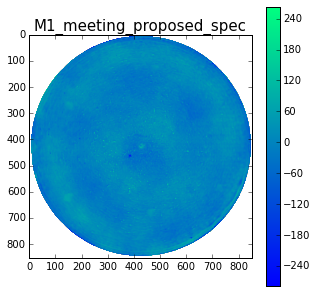

In [4]:
# Retrieve M1 polishing residuals
M = gmt.M1.modes.M.host(shape=(gmt.M1.modes.N_SAMPLE,gmt.M1.modes.N_SAMPLE,
                               gmt.M1.modes.N_SET*gmt.M1.modes.N_MODE))

print M.shape

fig, ax = plt.subplots()
fig.set_size_inches(5,5)
imm = ax.imshow(M[:,:,0]*1e9, cmap=plt.cm.winter)
fig.colorbar(imm, ax=ax)
ax.set_title(gmt.M1.mirror_modes_type, fontsize=15)

print("M1 figure map RMS: %0.2f"%(np.std(M[np.isfinite(M)])*1e9))

In [5]:
# Retrieve M2 KL modes
M2 = gmt.M2.modes.M.host(shape=(gmt.M2.modes.N_SAMPLE,gmt.M2.modes.N_SAMPLE,
                               gmt.M2.modes.N_SET*gmt.M2.modes.N_MODE))
print M2.shape

#Create circular mask
[rows,cols,nkls] = np.shape(M2)
xVec = np.linspace(-1,1,cols)
yVec = np.linspace(-1,1,rows)
[x,y] = np.meshgrid(xVec,yVec) # rows x cols
r = np.hypot(x,y)
M2mask = np.full((rows,cols),np.nan)
M2mask[(r <= 1)]=1.0
M2np = np.sum(r <= 1)

(256, 256, 2002)


RMS of KL mode 600 is: 0.71


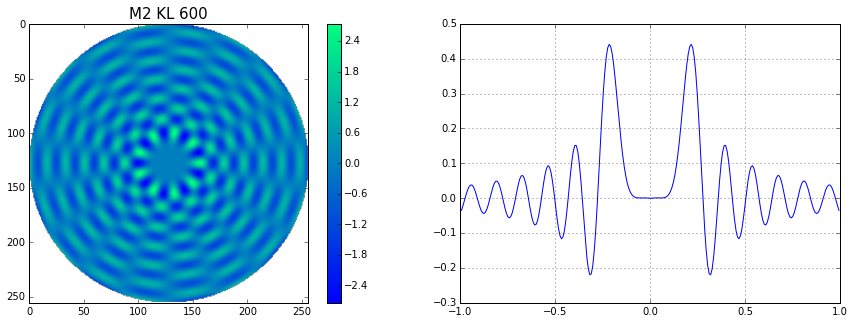

In [10]:
# Choose KL to display
this_kl = 600
KLmap = M2[:,:,this_kl]*M2mask
KLrms = np.sqrt( np.sum(KLmap[r<=1]**2)/M2np )
print("RMS of KL mode %d is: %.2f"%(this_kl, KLrms))
fig, (ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(15,5)
imm = ax1.imshow(KLmap, cmap=plt.cm.winter)
fig.colorbar(imm, ax=ax1)
ax1.set_title('M2 KL %d'%(this_kl), fontsize=15)

ax2.plot(xVec,KLmap[:,cols/2])
ax2.grid()

## On-axis AO system initialization
1. **on-axis geometrical SH sensor** with 75x75 sub-apertures
2. **on-axis idealized SPP sensor** controlling both turbulence and telescope segment piston.
3. **deformable mirror** controlling 300 KL modes / M2 segment

In [5]:
#---- Telescope sampling parameters (used when analyzing M1 polishing residuals)
D = 25.5
PupilArea = 357.0    # m^2
pixelSize = 0.015     # M1 map sampling: 1 cm/pix (set to 1.5 cm/pix due to memory limitations)
nPx = long(D/pixelSize)+1
p = D/(nPx-1)
print("Number of pixels across %1.1f-m array: %d"%(D,nPx))

Number of pixels across 25.5-m array: 1701


#### On-axis SH WFS Initialization

Total number of valid slopes: 11124


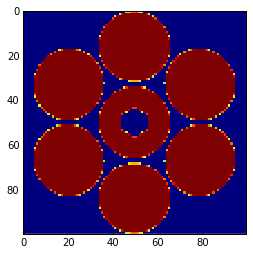

In [6]:
sh_thr = 0.5               # illumination threshold for valid SA selection
#nLenslet = 60  # original LTAO value
#nLenslet = 75  # use this when M1 map is sampled at 1 cm/pix.
#nLenslet = 85  # use this when M1 map is sampled at 1.5 cm/pix, and controlling 300 KLs
nLenslet = 100  # use this when M1 map is sampled at 1.5 cm/pix, and controlling 600 KLs


n = int((nPx-1)/nLenslet)  # number of pixels per subaperture
d = D/nLenslet
wfs = ceo.GeometricShackHartmann(nLenslet, d, N_GS=1)
gs = ceo.Source("R",zenith=0.,azimuth=0., rays_box_size=D, 
                rays_box_sampling=nPx, rays_origin=[0.0,0.0,25])

### Calibrate SH (valid SAs, slope null vector)
gs.reset()
gmt.reset()
gmt.propagate(gs)
ph_fda_on = gs.phase.host(units='nm')

wfs.calibrate(gs,sh_thr)
print("Total number of valid slopes: %d"%wfs.n_valid_slopes)
plt.imshow(wfs.valid_lenslet.f.host().reshape(nLenslet,nLenslet), interpolation='None')

#### Calibrate M2 KLs - SH Interaction Matrix and Reconstructor

In [7]:
# ----------- When using M1 polishing residuals and 600 KLs
### Calibrate IM and save or Restore from file
RECdir = "/storage/data02/201809-M1_Polishing_residuals"
fname = 'IM_SHgeom'+'_KLs600'+'_SHthr%1.1f_SAv%d_px%1.1fcm.npz'%(sh_thr,wfs.n_valid_slopes,pixelSize*100)
fnameFull = os.path.normpath(os.path.join(RECdir,fname))
fnameFull

'/storage/data02/201809-M1_Polishing_residuals/IM_SHgeom_KLs600_SHthr0.5_SAv11124_px1.5cm.npz'

In [8]:
z_first_mode = 1   #removes segment piston 
Zstroke = 20e-9 #m rms

if os.path.isfile(fnameFull) == False:    
    D_M2_MODES = gmt.calibrate(wfs, gs, mirror="M2", mode=u"Karhunen-Loeve", stroke=Zstroke, first_mode=z_first_mode)
    np.savez(fnameFull, D_M2=D_M2_MODES, first_mode=z_first_mode, Stroke=Zstroke)
else:
    print 'Reading file: '+fnameFull
    ftemp = np.load(fnameFull)
    D_M2_MODES = ftemp.f.D_M2
    ftemp.close()

nall = (D_M2_MODES.shape)[1]  ## number of modes calibrated
n_mode = nall/7

print 'AO SH WFS - M2 Segment Modal IM:'
print D_M2_MODES.shape

Reading file: /storage/data02/201809-M1_Polishing_residuals/IM_SHgeom_KLs600_SHthr0.5_SAv11124_px1.5cm.npz
AO SH WFS - M2 Segment Modal IM:
(11124, 4193)


In [9]:
### Extract IM with only "gmt.M2.modes.n_mode" KL modes:
D_M2_split = []
for kk in range(7):
    Dtemp = D_M2_MODES[:, kk*n_mode : n_mode*(kk+1)]
    D_M2_split.append(Dtemp[:, 0:gmt.M2.modes.n_mode-z_first_mode])

D_M2_MODES = np.concatenate(D_M2_split[0:7], axis=1) 
nall = (D_M2_MODES.shape)[1]  ## number of zernike DoFs calibrated
n_mode = nall/7

print 'AO SH WFS - M2 Segment Modal IM:'
print D_M2_MODES.shape

# free memory
del D_M2_split
del Dtemp

AO SH WFS - M2 Segment Modal IM:
(11124, 4193)


[[ 26.63687706  26.63416862  26.63410378  26.63688087  26.63416862
   26.63410378   9.32690048]]


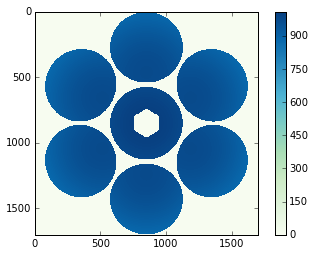

In [17]:
gmt.reset()
gmt.M2.modes.a[:,0] = 500e-9
#gmt.M2.modes.a[1,2] = 500e-9
#gmt.M2.modes.a[2,3] = 500e-9
gmt.M2.modes.update()

gs.reset()
gmt.propagate(gs)

wfs.reset()
wfs.analyze(gs)

onpsvec =  onps.piston(gs).ravel() - onps_signal_ref
AOmeasvec = np.concatenate((slopevec, onpsvec))
myAOest1 = np.dot(R_AO, AOmeasvec)

plt.imshow(gs.phase.host(units='nm'),interpolation='none', cmap=plt.cm.GnBu)
plt.colorbar()

print gs.phaseRms(where='segments')*1e9

(2080, 2111)

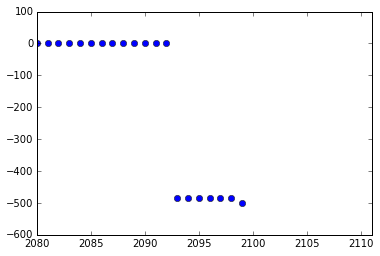

In [22]:
plt.plot(myAOest1*1e9, 'o')
plt.xlim([2080,2111])

#### On-axis Idealized Piston Sensor Initialization and IM Calibrations

SPP - SH IM:
___ M2 ___ (segment piston)
Segment #:1 2 3 4 5 6 7 
------------
SPP - SPS IM:
___ M2 ___ (segment piston)
Segment #:1 2 3 4 5 6 7 
------------


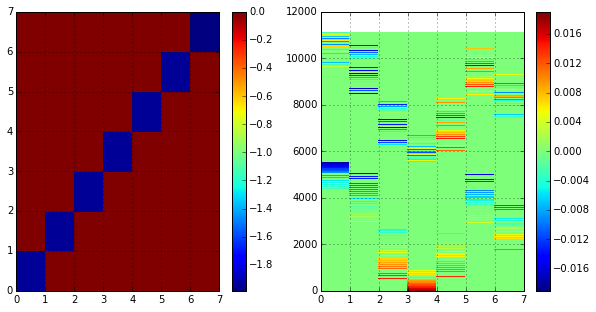

In [13]:
onps = ceo.IdealSegmentPistonSensor(gs, D, nPx, segment='full')
gs.reset()
gmt.reset()
gmt.propagate(gs)
onps_signal_ref = onps.piston(gs).ravel() #[0:6] # reference signal

#-----> SH - M2 segment piston IM
print("SPP - SH IM:")
PSstroke = 200e-9 #m
D_M2_PS_sh = gmt.calibrate(wfs, gs, mirror="M2", mode="segment piston", stroke=PSstroke)

#-----> Ideal SPS - M2 segment KLs IM
D_M2_MODES_PSideal = np.zeros((7,nall))

#-----> Ideal SPS - M2 segment piston IM
print("SPP - SPS IM:")
PSstroke = 50e-9 #m
D_M2_PSideal = gmt.calibrate(onps, gs, mirror="M2", mode="segment piston", stroke=PSstroke)

if VISU == True:
    fig, (ax1,ax2) = plt.subplots(ncols=2)
    fig.set_size_inches(10,5)
    imm = ax1.pcolor(D_M2_PSideal)
    ax1.grid()
    fig.colorbar(imm, ax=ax1)#, fraction=0.012)       

    imm1 = ax2.pcolor(D_M2_PS_sh)
    ax2.grid()
    fig.colorbar(imm1)

#### Merge interaction matrices and invert

In [14]:
#----> Create super-merger IM for "simplified NGAO control"
# DoFs: segment modes (KL2->KLx), segment Piston
# Sensors: on-axis SH WFS, on-axis idealized Piston Sensor

D_AO_SH = np.concatenate((D_M2_MODES, D_M2_PS_sh), axis=1)
print 'Merged (seg KL & Pist) - SH IM:'
print D_AO_SH.shape

D_AO_PS = np.concatenate((D_M2_MODES_PSideal, D_M2_PSideal), axis=1)
print 'Merged (seg KL & Pist) - Ideal SPS IM:'
print D_AO_PS.shape

D_AO = np.concatenate((D_AO_SH, D_AO_PS), axis=0)
print 'NGAO-ish super-merged IM:'
print D_AO.shape

Merged (seg KL & Pist) - SH IM:
(11124, 4200)
Merged (seg KL & Pist) - Ideal SPS IM:
(7, 4200)
NGAO-ish super-merged IM:
(11131, 4200)


In [15]:
# free memory
del D_AO_PS, D_AO_SH, D_M2_MODES_PSideal, D_M2_PSideal, D_M2_MODES, D_M2_PS_sh 

Condition number: 223.876299


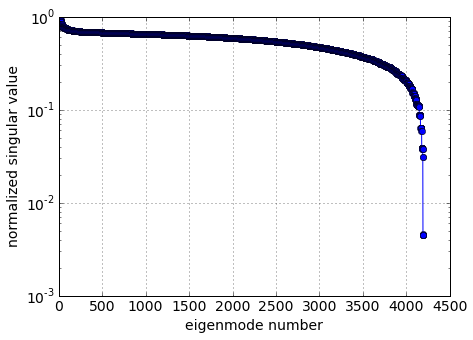

In [19]:
### SVD analysis of IM

#Choose interaction matrix:
#this_D = D_M2_MODES
this_D = D_AO
#this_D = D_M2_split[6]
print 'Condition number: %f'%np.linalg.cond(this_D)
Uz, Sz, Vz =np.linalg.svd(this_D)

fig, ax = plt.subplots()
fig.set_size_inches(7,5)

ax.semilogy(Sz/np.max(Sz), 'o-', )
ax.grid()
ax.tick_params(labelsize=14)
ax.set_xlabel('eigenmode number', fontsize=14)
ax.set_ylabel('normalized singular value', fontsize=14)
#ax.set_xlim([2400,2500])

In [16]:
ao_thr=1.0e-6
R_AO = np.linalg.pinv(D_AO, rcond=ao_thr)    
print 'AO SH WFS - M2 Segment Modal Rec:'
print R_AO.shape

AO SH WFS - M2 Segment Modal Rec:
(4200, 11131)


<matplotlib.colorbar.Colorbar instance at 0x7f81aa0442d8>

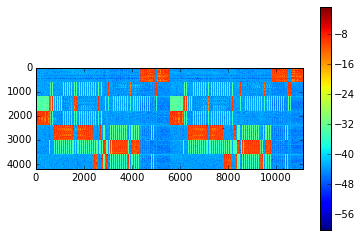

In [21]:
plt.imshow(np.log(np.abs(R_AO)))
plt.colorbar()

#### Propagate M1 or M2 shape to the exit pupil and visualize it just for fun

[[ 656.15808105  656.13122559  656.1295166   656.15808105  656.13128662
   656.1295166   696.31256104]]


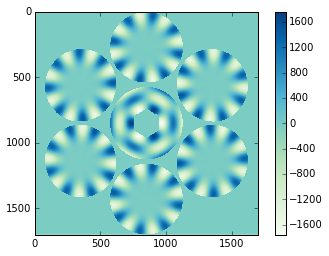

In [6]:
### Check a KL mode in the pupil (just for fun)
gs.reset()
gmt.reset()
gmt.M2.modes.a[:,33] = 500e-9
#gmt.M2.modes.a[1,2] = 500e-9
#gmt.M2.modes.a[2,3] = 500e-9
gmt.M2.modes.update()
gmt.propagate(gs)

plt.imshow(gs.phase.host(units='nm'),interpolation='none', cmap=plt.cm.GnBu)
plt.colorbar()

print gs.phaseRms(where='segments')*1e9

[[ 38.37497711  38.3989296   38.42063904  38.3749733   38.39892578
   38.42063904  38.7717247 ]]


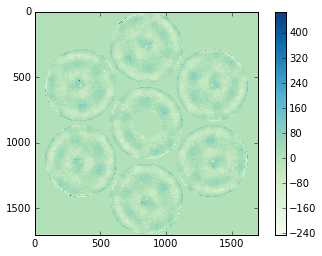

In [7]:
### Check M1 polishing residuals in the pupil (just for fun)
gs.reset()
gmt.reset()
gmt.M1.modes.a[:,0] = 1.0
gmt.M1.modes.update()
gmt.propagate(gs)

plt.imshow(gs.phase.host(units='nm'),interpolation='none', cmap=plt.cm.GnBu)
plt.colorbar()

print gs.phaseRms(where='segments')*1e9

## Atmospheric Turbulence initialization

In [17]:
simul_turb=True
atm_fname = '/mnt/bins/gmtAtmosphereL025_1234.json'

# Turbulence parameters:
if simul_turb == True:
    atm = ceo.JGmtAtmosphere(jsonfile=atm_fname)
    r0 = atm.r0
    L0 = atm.L0
    print r0, L0

@(ceo.JGmtAtmosphere)>
{
  "fov": 0.005817764173314432,
  "r0": 0.15,
  "L": 26.0,
  "filename": "/mnt/bins/gmtAtmosphereL025_1234.bin",
  "N_DURATION": 20,
  "L0": 25,
  "NXY_PUPIL": 346,
  "duration": 15,
  "SEED": 1234
}
0.15000000596 25.0


## Coronagraph initialization


### Perfect coronagraph
The perfect coronagraph subtracts an Airy pattern from the complex amplitude of the incoming field wave in a proportion that minimizes the energy coming out from the coronagraphic mask (Sauvage et al., JOSAA Vol. 27, No. 11, 2010).

The focal plane amplitude in the detector plane with a perfect coronagraph is:

$ A_{pc}(\boldsymbol{\rho},t) = A(\boldsymbol{\rho},t) - \sqrt{SR(t)} A_{dl}(\boldsymbol{\rho},t)$ <br/> 
where: <br/>
$ A(\boldsymbol{\rho},t) = \mathbf{FT}\{P_d(\boldsymbol{\rho}) e^{j\phi(\boldsymbol{\rho},t)}\}  $  and $ A_{dl}(\boldsymbol{\rho},t) = \mathbf{FT}\{P_d(\boldsymbol{\rho})\}  $
<br/> where: <br/> 
$\boldsymbol{\rho}$: spatial vector in the exit pupil; <br/> $P_d(\boldsymbol{\rho})$: normalized telescope pupil mask; <br/> $\phi(\boldsymbol{\rho},t)$: phase at the entrance pupil; <br/> $SR(t)$: instantaneous Strehl Ratio.

The instantaneous coronagraphic image is then computed as: <br/>
$h(\boldsymbol{\rho},t) = \|A_{pc}(\boldsymbol{\rho},t)\|^2 $


In [18]:
#-- Select imaging wavelength
#lim = gs.wavelength
lim = 3.77e-6 # L' band
knumber = 2.*np.pi/lim

In [19]:
#-- Complex Amplitude computation.
#     Inputs: None. It uses current amplitude and phase of gs object
#     Keywords: FT: if True, returns the FT of the complex amplitude
def complex_amplitude(FT=False):
    A0 = np.zeros((nPx*npad-1,nPx*npad-1))
    A0[0:nPx,0:nPx] = gs.amplitude.host()
    F0 = np.zeros((nPx*npad-1,nPx*npad-1))
    F0[0:nPx,0:nPx] = gs.phase.host()
    if FT==False:
        return A0*np.exp(1j*knumber*F0)
    else:
        return np.fft.fft2(A0*np.exp(1j*knumber*F0))

#-- Short exposure PSF computation.
#     Input: W_ft -> Fourier Transform of the complex amplitude
def psf_se(W_ft, shifted=False, norm_factor=1):
    if shifted==True:
        return np.fft.fftshift( np.abs(W_ft)**2 ) / norm_factor
    else:
        return np.abs(W_ft)**2 / norm_factor

#-- Perfect coronagraph PSF computation
def perfect_coro_psf_se(shifted=False, norm_factor=1):
    W1_ft = complex_amplitude(FT=True)
    SR_se = np.exp(-(knumber*gs.phaseRms())**2)  # Marechal approximation
    Wc_ft = W1_ft - np.sqrt(SR_se)*W0_ft
    return psf_se(Wc_ft, shifted=shifted, norm_factor=norm_factor)   

In [20]:
#-- Compute diff-limited quantities (A_dl, PSF, ...)
gs.reset()
gmt.reset()
gmt.propagate(gs)

npad = 2 # npad=2 for Nyquist sampling of PSF
W0_ft = complex_amplitude(FT=True)
norm_pup = np.sum(gs.amplitude.host())**2

In [21]:
#-- Initialize variables to visualize PSFs and produce radial profiles
fp_pixscale = lim/(npad*D)*ceo.constants.RAD2MAS  #mas/pixel in focal plane

PSF0 = psf_se(W0_ft, shifted=True, norm_factor=norm_pup)
nfx, nfy = PSF0.shape
Xf, Yf = np.ogrid[0:nfx, 0:nfy]
Rf = np.hypot(Xf-nfx/2, Yf-nfy/2) * fp_pixscale # distance from PSF center in mas

binSize = fp_pixscale # bin size for radial average in mas
nbins = np.round(Rf.max()/binSize)
Rflabel = (nbins * Rf/Rf.max()).astype(np.int)
Rfidx = np.arange(0,Rflabel.max()+1)
Rfvec = (Rfidx * binSize) + binSize/2

PSF0prof = ndimage.mean(PSF0, labels=Rflabel, index=Rfidx)

In [22]:
#-- Funcdtion to show PSF and radial profile
#   im_display_size: +/- mas from center
def show_psf_and_profile(myPSF, myProf, im_display_size=150):
    fig, (ax1,ax2) = plt.subplots(ncols=2)
    fig.set_size_inches(14,5)

    im_range_mas = np.array([-im_display_size, im_display_size])
    im_range_pix = np.round(im_range_mas/fp_pixscale + nPx*npad/2).astype(int)

    imm = ax1.imshow(np.log10(myPSF[im_range_pix[0]:im_range_pix[1],im_range_pix[0]:im_range_pix[1]]), 
               extent=[-im_display_size,im_display_size,-im_display_size,im_display_size], 
                     origin='lower', interpolation=None)
    clb = fig.colorbar(imm, ax=ax1)
    imm.set_clim([-10,0])
    ax1.set_xlabel('mas')

    ax2.loglog(Rf.ravel(), myPSF.ravel(), '.')
    ax2.hold('on')
    ax2.loglog(Rfvec,myProf, 'r', linewidth=3)
    ax2.hold('off')
    ax2.set_xlim([1,1e4])
    ax2.set_ylim([1e-10,1])
    ax2.grid()
    ax2.set_xlabel('radial distance [mas]')
    ax2.set_ylabel('normalized intensity')  

Strehl ratio @ 3770.00 nm of diff-limited PSF: 1.00


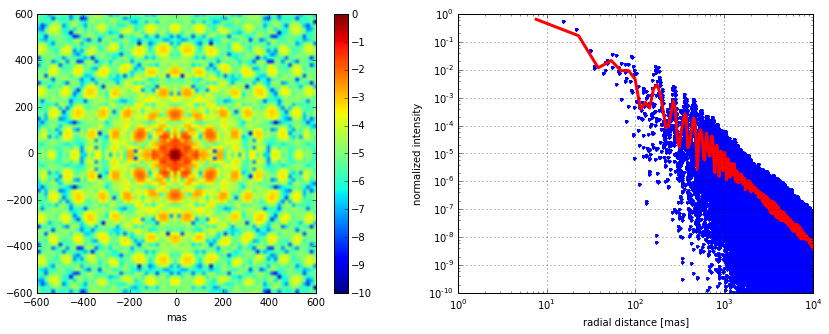

In [24]:
#-- Show diff.-limited PSF and profile
show_psf_and_profile(PSF0, PSF0prof, im_display_size=600)
print('Strehl ratio @ %.2f nm of diff-limited PSF: %.2f'%(lim*1e9,np.max(PSF0)))

# Contrast evaluation
1. Introduce selected errors
2. Simulate closed-loop AO correction
3. Produce a long-exposure coronagraphic PSF for radially-average contrast evaluation

In [25]:
### Select error sources
simul_M1polish = False  # M1 polishing residuals
simul_turb = True # atmospheric turbulence
simul_onaxis_AO = True

gs.reset()
wfs.reset()
gmt.reset()

#### Introduce M1 figure residuals on M1

WF RMS: 38.4 nm
SPP RMS: 0.2 nm


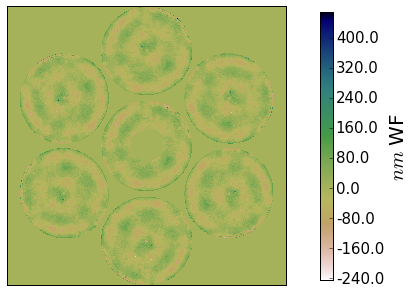

In [86]:
if simul_M1polish==True:

    # Introduce Active Optics residuals (after 27 bending modes)
    gmt.M1.modes.a[:,0] = 1   # coefficient of 1.0 means nominal M1 figure (RMS 22 nm Surf)
    gmt.M1.modes.update()
    #gmt.M1.motion_CS.origin[0,2] = 500e-9
    #gmt.M1.motion_CS.update()

    #gmt.M2.modes.a[:,3] = 500e-9
    #gmt.M2.modes.update()

    gmt.propagate(gs)
    fig, ax = plt.subplots()
    fig.set_size_inches(20,5)
    InitScr = gs.phase.host(units='nm')-ph_fda_on
    imm = ax.imshow(InitScr, interpolation='None',cmap=plt.cm.gist_earth_r,origin='lower')#,vmin=-25, vmax=25)
    ax.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
    clb = fig.colorbar(imm, ax=ax, fraction=0.012, pad=0.03,format="%.1f")
    clb.set_label('$nm$ WF', fontsize=20)
    #clb.set_label('nm WF', fontsize=25)
    clb.ax.tick_params(labelsize=15)

    print('WF RMS: %.1f nm'%(gs.phaseRms()*1e9))
    print('SPP RMS: %.1f nm'%(np.std(gs.piston('segments'))*1e9))

#### Compute PSF of WF with M1 polishing residuals

Strehl ratio @ 3770.00 nm of aberrated PSF: 1.00


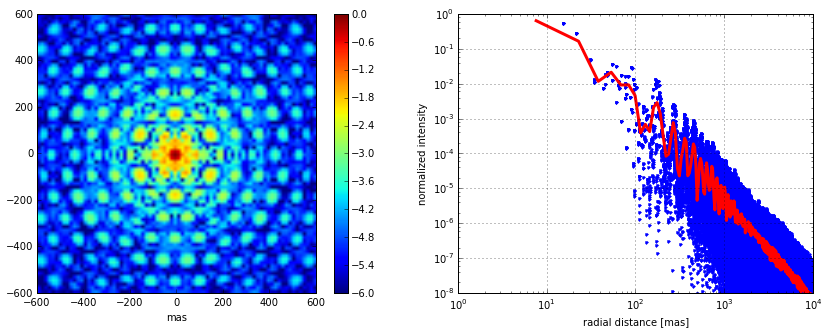

In [88]:
if simul_M1polish==True:
    PSF1 = psf_se(complex_amplitude(FT=True), shifted=True, norm_factor=norm_pup)
    PSF1prof = ndimage.mean(PSF1, labels=Rflabel, index=Rfidx)
    print('Strehl ratio @ %.2f nm of aberrated PSF: %.2f'%(lim*1e9,np.max(PSF1)))

    #-- Show diff.-limited PSF and profile
    show_psf_and_profile(PSF1, PSF1prof, im_display_size=600)

#### Compute coronagraphic PSF with solely M1 polishing residuals
Note: this assumes a perfect correction of 27 bending modes by Active Optics

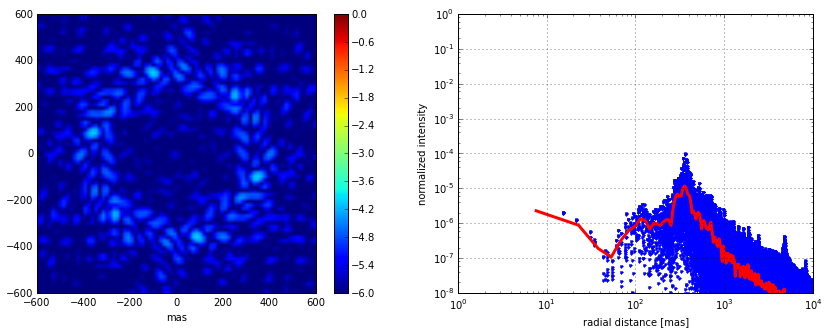

In [90]:
if simul_M1polish==True:
    PSFc = perfect_coro_psf_se(shifted=True, norm_factor=norm_pup)
    PSFcprof = ndimage.mean(PSFc, labels=Rflabel, index=Rfidx)
    show_psf_and_profile(PSFc, PSFcprof, im_display_size=600)

#### Close the on-axis AO loop

 iter: 4/15, ET: 1.1 s, on-axis WF RMS [nm]: 72.450
Start accumulating PSFs

 iter: 14/15, ET: 8.2 s, on-axis WF RMS [nm]: 71.6

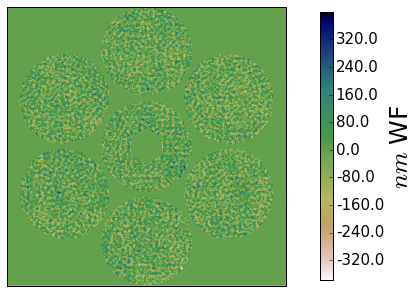

In [26]:
totSimulIter = 15
totSimulInit = 5
messageCount = 0
Tsim = 1e-3  #simulation time step [seconds]
gAO = 0.9
a_M2_iter = np.zeros((7,n_mode,totSimulIter))
M2PSiter  = np.zeros((7,totSimulIter))
myAOest1 = np.zeros(nall+7) 
onpsvec = np.zeros(7)

wfe_gs_iter           = np.zeros(totSimulIter)
seg_wfe_onaxis_iter   = np.zeros((7,totSimulIter))

for jj in range(totSimulIter):
    tid.tic()
    gs.reset()
    
    #----- Update Turbulence --------------------------------------------
    if simul_turb == True:
        if simul_onaxis_AO==True:
            atm.ray_tracing(gs, p,nPx,p,nPx, jj*Tsim)
            
    #----- Apply AO correction -----------------------------------
    gmt.M2.modes.a[:,z_first_mode:] -= myAOest1[0:nall].reshape((7,-1))
    a_M2_iter[:,:,jj] = gmt.M2.modes.a[:,z_first_mode:]
    gmt.M2.modes.update()

    gmt.M2.motion_CS.origin[:,2] -= myAOest1[nall:]
    M2PSiter[:,jj] = gmt.M2.motion_CS.origin[:,2]
    gmt.M2.motion_CS.update()

    #----- On-axis WFS measurement and command computation--------
    gmt.propagate(gs)
    wfs.reset()
    wfs.analyze(gs)
    slopevec = wfs.get_measurement()
    onpsvec =  onps.piston(gs).ravel() - onps_signal_ref
    AOmeasvec = np.concatenate((slopevec, onpsvec))
    myAOest1 = np.dot(R_AO, AOmeasvec)
    myAOest1 *= gAO        

    wfe_gs_iter[jj] = gs.wavefront.rms()
    seg_wfe_onaxis_iter[:,jj] = gs.phaseRms(where='segments', units_exponent=-9)

    #----- Accumulate short-exposure PSFs
    if jj >= totSimulInit:
        while messageCount == 0:
            print('\nStart accumulating PSFs\n')
            messageCount = 1
            PSFle = perfect_coro_psf_se(shifted=True, norm_factor=norm_pup)
            #PSFle = psf_se(complex_amplitude(FT=True), shifted=True, norm_factor=norm_pup)
        PSFle += perfect_coro_psf_se(shifted=True, norm_factor=norm_pup)
        #PSFle += psf_se(complex_amplitude(FT=True), shifted=True, norm_factor=norm_pup)
        
    
    tid.toc()
    sys.stdout.write("\r iter: %d/%d, ET: %.1f s, on-axis WF RMS [nm]: %.1f"%(jj, totSimulIter, tid.elapsedTime*1e-3, gs.phaseRms()*1e9))
    sys.stdout.flush() 

# Compute Long-Exposure PSF
PSFle /= (totSimulIter-totSimulInit)

#-- show final on-axis residual map
fig, ax = plt.subplots()
fig.set_size_inches(20,5)
imm = ax.imshow(gs.phase.host(units='nm')-ph_fda_on, interpolation='None',cmap=plt.cm.gist_earth_r, origin='lower')#, vmin=-25, vmax=25)
#ax.set_title('on-axis WF')
ax.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
clb = fig.colorbar(imm, ax=ax, fraction=0.012, pad=0.03,format="%.1f")
clb.set_label('$nm$ WF', fontsize=25)
clb.ax.tick_params(labelsize=15)

#print('on-axis WF RMS: %.1f nm'%(gs.phaseRms()*1e9))
#print('on-axis SPP RMS: %.1f nm'%(np.std(gs.piston('segments'))*1e9))

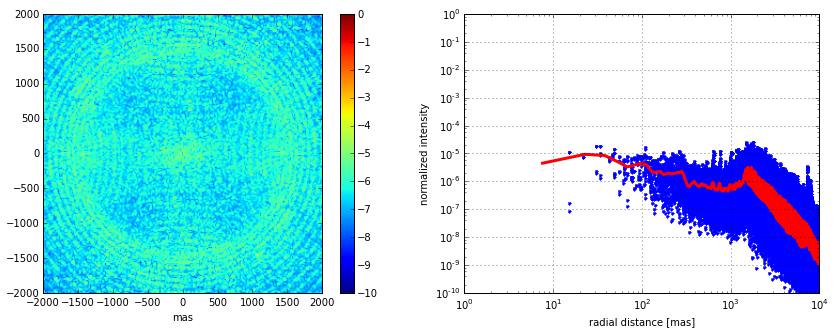

In [28]:
#PSFle = perfect_coro_psf_se(shifted=True, norm_factor=norm_pup)
#PSFleprof = ndimage.mean(PSFle, labels=Rflabel, index=Rfidx)
show_psf_and_profile(PSFle, PSFleprof, im_display_size=2000)

In [62]:
print('Strehl ratio @ %.2f nm of aberrated PSF: %.2f'%(lim*1e9,np.max(PSFle)))

Strehl ratio @ 640.00 nm of aberrated PSF: 0.00


#### Check AO convergence

Final WFE [nm RMS]: 24.1
Equivalent SR in K band: 0.9953


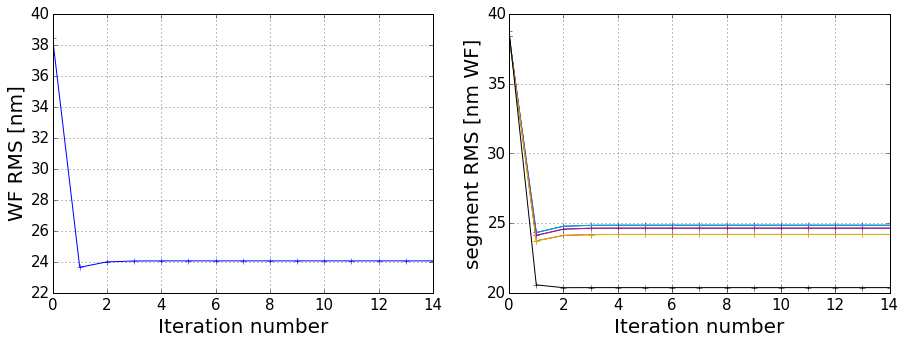

In [67]:
#### on-axis WFE vs. iteration number
fig, (ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(15,5)
ax1.plot(wfe_gs_iter*1e9, '-+')
ax1.grid()
ax1.set_xlabel('Iteration number', fontsize=20)
ax1.set_ylabel('WF RMS [nm]', fontsize=20)
ax1.tick_params(labelsize=15)

#### on-axis segment WFE vs. iteration number
ax2.plot(seg_wfe_onaxis_iter.T, '-+')
ax2.grid()
ax2.set_xlabel('Iteration number', fontsize=20)
ax2.set_ylabel('segment RMS [nm WF]', fontsize=20)
ax2.tick_params(labelsize=15)

wfe_final = wfe_gs_iter[-1]
print ('Final WFE [nm RMS]: %3.1f'%(wfe_final*1e9))
print ('Equivalent SR in K band: %1.4f'%(np.exp(-(wfe_final*2*np.pi/2.2e-6)**2)))

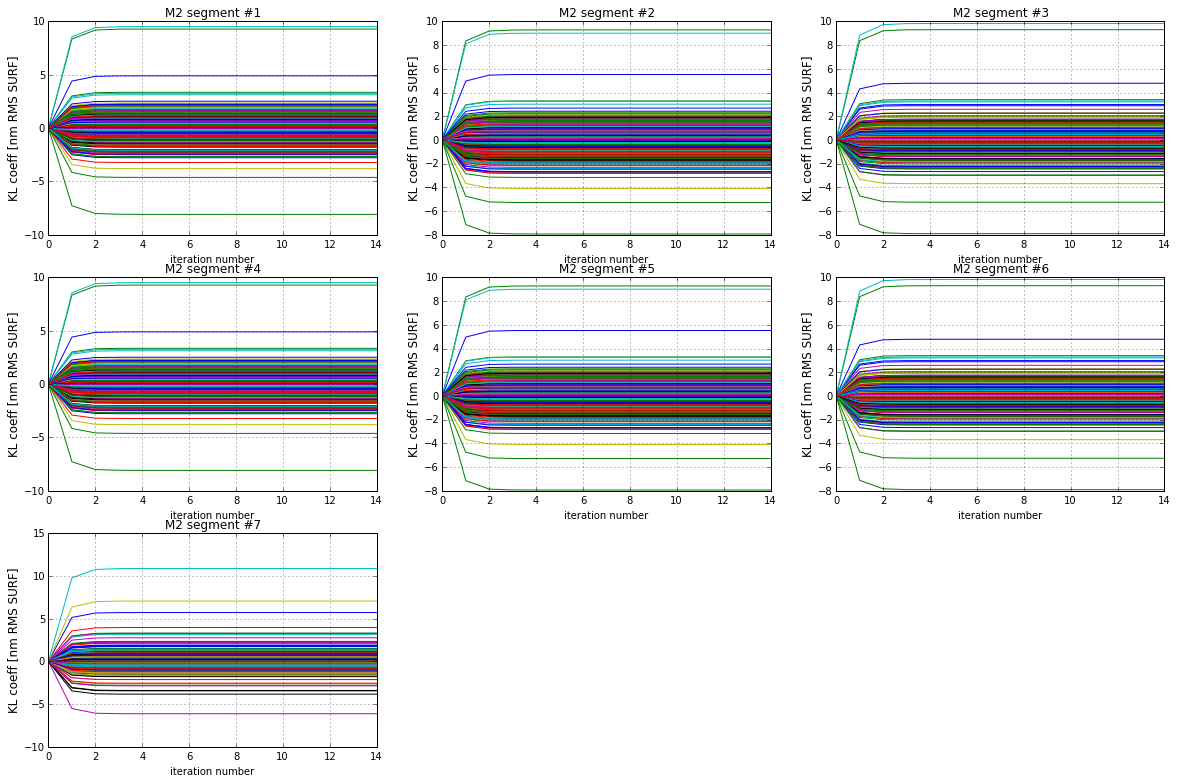

In [68]:
### Residual M2 segment Zernikes
f1, ax = plt.subplots(ncols=3, nrows=3)
f1.set_size_inches(20,13)
for jj in range(7):
    thisax = (ax.ravel())[jj]
    thisax.plot(a_M2_iter[jj,:,:].T*1e9)
    thisax.grid()
    thisax.set_title('M2 segment #%d'%(jj+1), size='large')
    thisax.set_xlabel('iteration number')
    thisax.set_ylabel('KL coeff [nm RMS SURF]', size='large')

for k in range(7,9):
    (ax.ravel())[k].axis('off')